## BIRD-GP: A Synthesized Fashion MNIST Example

### Install from Github

In [1]:
!pip install git+https://github.com/guoxuan-ma/2022_BIRD_GP

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/guoxuan-ma/2022_BIRD_GP to /tmp/pip-req-build-1bd8x_qk
  Running command git clone -q https://github.com/guoxuan-ma/2022_BIRD_GP /tmp/pip-req-build-1bd8x_qk
  Created wheel for bird-gp: filename=bird_gp-0.0.1-py3-none-any.whl size=11118 sha256=f5d8d3f8062f4aa554c871b0a3f7f1bce4bad9ad67c92802fd30fa5c668ad274
  Stored in directory: /tmp/pip-ephem-wheel-cache-nsaoynlk/wheels/84/9d/01/56796991036d59d1f313b8d94b70367917b1e6199928754e0f
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1319 sha256=d952a02a94b2cb112d242e17502552fe3e9f80432a301dbcd688474bcae897a7
  Stored in directory: /root/.cache/pip/wheels/c6/f0/d9/9fa5ff78c0f9d5a0a427bbbb4893c283520ddfccb885ea2205
Successfully built bird-gp tdqm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import bird_gp
import random
import torch

### Read images and generate synthesized images

In [3]:
#####################################################################
# read images
train_data = np.loadtxt("fashion_mnist_train_example_data.txt")
test_data = np.loadtxt("fashion_mnist_test_example_data.txt")

train_imgs = train_data[:, 1:]
test_imgs = test_data[:, 1:]
train_lbs = train_data[:, 0]
test_lbs = test_data[:, 0]
train_imgs = train_imgs / 255
test_imgs = test_imgs / 255

n_train = train_imgs.shape[0]
n_test = test_imgs.shape[0]
n = n_train + n_test

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

#####################################################################
# generate images
train_quantiles = np.zeros((4, n_train))
for i in range(n_train):
    train_img_i = train_imgs[i, :]
    train_img_i = train_img_i[train_img_i > 0]
    train_quantiles[:, i] = np.quantile(train_img_i, [0, 0.25, 0.5, 0.75])

train_q0 = np.tile(train_quantiles[0, :].reshape((n_train, 1)), (1, 784))
train_q1 = np.tile(train_quantiles[1, :].reshape((n_train, 1)), (1, 784))
train_q2 = np.tile(train_quantiles[2, :].reshape((n_train, 1)), (1, 784))
train_q3 = np.tile(train_quantiles[3, :].reshape((n_train, 1)), (1, 784))

train_p0 = np.zeros((n_train, 784))
train_p1 = np.zeros((n_train, 784))
train_p2 = np.zeros((n_train, 784))
train_p3 = np.zeros((n_train, 784))

train_p3[train_imgs >= train_q3] = train_imgs[train_imgs >= train_q3]
train_p2[(train_imgs >= train_q2) & (train_imgs < train_q3)] = train_imgs[(train_imgs >= train_q2) & (train_imgs < train_q3)]
train_p1[(train_imgs >= train_q1) & (train_imgs < train_q2)] = train_imgs[(train_imgs >= train_q1) & (train_imgs < train_q2)]
train_p0[(train_imgs >= train_q0) & (train_imgs < train_q1)] = train_imgs[(train_imgs >= train_q0) & (train_imgs < train_q1)]

train_predictors = np.zeros((n_train, 28*28*4))
train_outcomes = train_imgs
for i in range(n_train):
    train_p0_i = train_p0[i, :].reshape((28, 28))
    train_p1_i = train_p1[i, :].reshape((28, 28))
    train_p2_i = train_p2[i, :].reshape((28, 28))
    train_p3_i = train_p3[i, :].reshape((28, 28))
    train_predictor_i = np.hstack((train_p0_i, train_p1_i, train_p2_i, train_p3_i))
    train_predictors[i, :] = train_predictor_i.reshape(-1)

test_quantiles = np.zeros((4, n_test))
for i in range(n_test):
    test_img_i = test_imgs[i, :]
    test_img_i = test_img_i[test_img_i > 0]
    test_quantiles[:, i] = np.quantile(test_img_i, [0, 0.25, 0.5, 0.75])


test_q0 = np.tile(test_quantiles[0, :].reshape((n_test, 1)), (1, 784))
test_q1 = np.tile(test_quantiles[1, :].reshape((n_test, 1)), (1, 784))
test_q2 = np.tile(test_quantiles[2, :].reshape((n_test, 1)), (1, 784))
test_q3 = np.tile(test_quantiles[3, :].reshape((n_test, 1)), (1, 784))

test_p0 = np.zeros((n_test, 784))
test_p1 = np.zeros((n_test, 784))
test_p2 = np.zeros((n_test, 784))
test_p3 = np.zeros((n_test, 784))

test_p3[test_imgs >= test_q3] = test_imgs[test_imgs >= test_q3]
test_p2[(test_imgs >= test_q2) & (test_imgs < test_q3)] = test_imgs[(test_imgs >= test_q2) & (test_imgs < test_q3)]
test_p1[(test_imgs >= test_q1) & (test_imgs < test_q2)] = test_imgs[(test_imgs >= test_q1) & (test_imgs < test_q2)]
test_p0[(test_imgs >= test_q0) & (test_imgs < test_q1)] = test_imgs[(test_imgs >= test_q0) & (test_imgs < test_q1)]

test_predictors = np.zeros((n_test, 28*28*4))
test_outcomes = test_imgs
for i in range(n_test):
    test_p0_i = test_p0[i, :].reshape((28, 28))
    test_p1_i = test_p1[i, :].reshape((28, 28))
    test_p2_i = test_p2[i, :].reshape((28, 28))
    test_p3_i = test_p3[i, :].reshape((28, 28))
    test_predictor_i = np.hstack((test_p0_i, test_p1_i, test_p2_i, test_p3_i))
    test_predictors[i, :] = test_predictor_i.reshape(-1)

### Generate grids

In [4]:
predictor_grids = bird_gp.generate_grids([28, 112])
outcome_grids = bird_gp.generate_grids([28, 28])

### Create BIRD_GP object and fit

fit basis for predictors ...


100%|██████████| 10000/10000 [11:35<00:00, 14.37it/s]


fit basis for outcomes ...


100%|██████████| 10000/10000 [03:17<00:00, 50.73it/s]


basis orthogonalization ...
fit basis coefficients for predictors ...


100%|██████████| 1000/1000 [09:26<00:00,  1.76it/s]


fit basis coefficients for outcomes ...


100%|██████████| 1000/1000 [09:30<00:00,  1.75it/s]


stein variation gradient descent ...
epoch: 1 / 30, training rmse: 1.6287, training r2: 0.126
epoch: 2 / 30, training rmse: 1.5065, training r2: 0.2523
epoch: 3 / 30, training rmse: 1.3739, training r2: 0.3781
epoch: 4 / 30, training rmse: 1.2235, training r2: 0.5068
epoch: 5 / 30, training rmse: 1.0598, training r2: 0.6299
epoch: 6 / 30, training rmse: 0.8986, training r2: 0.7339
epoch: 7 / 30, training rmse: 0.762, training r2: 0.8087
epoch: 8 / 30, training rmse: 0.6578, training r2: 0.8574
epoch: 9 / 30, training rmse: 0.5822, training r2: 0.8883
epoch: 10 / 30, training rmse: 0.5321, training r2: 0.9067
epoch: 11 / 30, training rmse: 0.4995, training r2: 0.9178
epoch: 12 / 30, training rmse: 0.476, training r2: 0.9254
epoch: 13 / 30, training rmse: 0.4608, training r2: 0.93
epoch: 14 / 30, training rmse: 0.4492, training r2: 0.9335
epoch: 15 / 30, training rmse: 0.4426, training r2: 0.9355
epoch: 16 / 30, training rmse: 0.4352, training r2: 0.9376
epoch: 17 / 30, training rmse: 0.

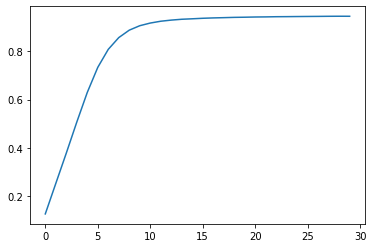

In [5]:
birdgp = bird_gp.BIRD_GP(predictor_grids = predictor_grids,
                         outcome_grids = outcome_grids,
                         predictor_L = 50,
                         outcome_L = 50,
                         svgd_b_lambda = 1e2, 
                         bf_predictor_steps = 10000,
                         bf_outcome_steps = 10000)
birdgp.fit(train_predictors, train_outcomes)

### Evaluation on training data

In [6]:
train_pred = birdgp.predict_train()
np.mean((train_pred - train_outcomes)**2)

0.024533286114017255

### Evaluation on testing data

In [7]:
test_pred = birdgp.predict_test(test_predictors)
np.mean((test_pred - test_outcomes)**2)

100%|██████████| 1000/1000 [09:29<00:00,  1.76it/s]


0.02714640670307424